
# **GPytorch Sparse Gaussian Processes Tutorial**



The first step will be to investigate the computational cost of exact GP regression. For that, we will consider a simple toy problem and will record training time, for increasing number of data instances.


In [1]:
!pip install gpytorch==1.13

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import math
import torch
import gpytorch
import numpy as np
from torch.nn import Parameter
from matplotlib import pyplot as plt

# We use double precision

torch.set_default_tensor_type(torch.DoubleTensor)

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


We define the model we will be using. A exact GP for regression.


In [3]:
# We create a class called ExactGPModel that inheritates from ExactGP and sets custom
# mean and covariance functions.

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):

        # We call the superclass with the training data and the associated likelihood.

        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        # We consdier a constant mean equal to zero, which the typical case.

        self.mean_module = gpytorch.means.ZeroMean()

        # We consider a squared exponential (RBF) kernel with an amplitude (scale) parameter.

        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):

        # The forwward method simply computes the prior means and covariances of the
        # process values associated to the input data.

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # We return a multivariate Gaussian distribution with teh corresponding mean
        # and covariances.

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

We now create the training data that we will be using.

In [4]:
N = 100

# Training data are N points regularly spaced in the interval [0,1].

train_x = torch.linspace(0, 1, N)

# True function is sin(2*pi*x) with additive Gaussian noise with variance 0.04.

train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

We plot the generated data for visualization.

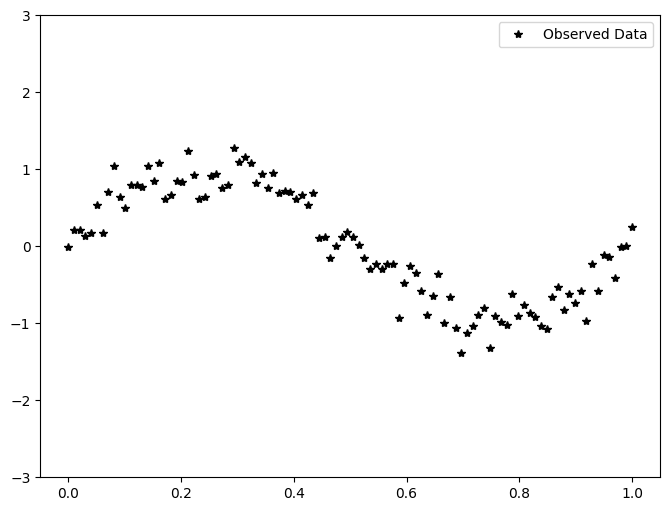

In [5]:
# Initialize plot

f, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot training data as black stars

ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data'])

### **Creaing the Model and Training**

We train the GP using the L-BFGS method.

In [6]:
import time

model = ExactGPModel(train_x, train_y, likelihood)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train_model(model, mll, train_x, train_y, training_iter = 10, likelihood = None):

  model.train()
  losses = torch.zeros(training_iter)

  # We check if we have to optimize the likelihood too or it is already in the
  # model

  if likelihood is None:
    params = model.parameters()
  else:
    params = list(model.parameters()) + list(likelihood.parameters())

  # We instantiate the LBFGS optimizer, which will optimize the hyper-parameters.

  optimizer = torch.optim.LBFGS(params, \
      history_size=10, max_iter=4, line_search_fn="strong_wolfe")

  def closure():
      optimizer.zero_grad()
      output = model(train_x)
      loss = -mll(output, train_y)
      loss.backward()
      return loss

  for i in range(training_iter):

    loss = -mll(model(train_x), train_y) * train_x.shape[ 0 ]
    print('Iter %d/%d - Loss: %f' % (i + 1, training_iter, loss.item()))
    losses[ i ] = torch.from_numpy(np.array([loss.item()]))

    optimizer.step(closure)

  return losses

start = time.time()
result = train_model(model, mll, train_x, train_y)
end = time.time()

print("Total training time:", end - start)

Iter 1/10 - Loss: 66.150027
Iter 2/10 - Loss: -0.554608
Iter 3/10 - Loss: -2.997554
Iter 4/10 - Loss: -3.181387
Iter 5/10 - Loss: -3.324073
Iter 6/10 - Loss: -3.324321
Iter 7/10 - Loss: -3.324321
Iter 8/10 - Loss: -3.324321
Iter 9/10 - Loss: -3.324321
Iter 10/10 - Loss: -3.324321
Total training time: 0.40657877922058105


## **Task 1**

Try changing the number of training instances N to larger, and larger values. Write down the training time observed for each value of N. You should see a cubic training cost. That is, 2 times larger N results in 8 times larger training time. Start with N = 100 and finish with N = 4000. Double the value of N each time. Use local execution, if possible, for more reliable results. You should observe that for a few thousand data instances, the training  times start to be too large and hence, using exact GPs for regression is only possible in fairly small datasets.


For the next tasks, we will consider N = 1000 points in the previous problem.

In [7]:
N = 1000

# Training data are N points regularly spaced in the interval [0,1].

train_x = torch.linspace(0, 1, N)

# True function is sin(2*pi*x) with additive Gaussian noise with variance 0.04.

train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

## **Sparse GPs via Nyström Approximation**

Nyström's approximation of the covariance matrix to speed-up the computations of GPs is not directly implemented in GPytorch. However, it is very easy to extend the model to consider it. With this goal, we create a specific covariance function that will do the computations as indicated in the Nyström approximation.



In [8]:
# Custom covairance function to implement the Nyström approximation.
# This covariance function is equal to InducingPointKernel, but without
# adding extra regularization terms (Eq. 9 of Titsias 2009) to the MLL.

class NystromKernel(gpytorch.kernels.InducingPointKernel):
    def forward(self, x1, x2, diag=False, **kwargs):
      covar = self._get_covariance(x1, x2)

      if self.training:
        if not torch.equal(x1, x2):
                raise RuntimeError("x1 should equal x2 in training mode")

      if diag:
        return covar.diagonal(dim1=-1, dim2=-2)
      else:
        return covar

The previous kernel implementes the Nyström approximation to the covariances. Recall from what we have seen in the lectures that it is:
$$\Sigma = \Sigma_{N,M}\Sigma_{M,M}^{-1}\Sigma_{N,M}$$
Now, we can define our model. A standard GP using that particular covariance function.

In [9]:
# We define our approximate GP method based on the Nyström approximation

class NystromSparseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, random_points, likelihood):

        # We call the superclass with the training data and the associated likelihood.

        super(NystromSparseGPModel, self).__init__(train_x, train_y, likelihood)

        # We consdier a constant mean equal to zero, which the typical case.

        self.mean_module = gpytorch.means.ZeroMean()

        # We consider a squared exponential (RBF) kernel with an amplitude (scale) parameter.
        # We use the kernel InducingPointKernel provided in Gpytorch. This kernel will compute
        # approximate covariances as in the Nystrom approximation.

        self.random_points = random_points
        self.covar_module = NystromKernel(\
              gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()), \
              random_points, likelihood)

        # We make the inducing points be constant and prevent their optimization.

        self.covar_module.inducing_points.requires_grad = False

        # We specify that we do not want to add the diagonal correction of FITC

        # By default, GPytorch implements the FITC approximation for sparse GP
        # when using the kernel "InducingPointKernel". However, that kernel is
        # very closely related to the one used in the Nyström approximation.
        # One simply has to remove the extra diagonal term that is added to
        # the diagonal. This is achieved by the previous defined kernel.

    def forward(self, x):

        # We do not add the diagonal correction of the FITC approximation

        gpytorch.settings.sgpr_diagonal_correction(False)

        # The forwward method simply computes the prior means and covariances of the
        # process values associated to the input data.

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # We return a multivariate Gaussian distribution with the corresponding mean
        # and covariances.

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

That is it! We are now ready to use the previos object for regression with a faster computational cost than the exact GP method. We test it on the previous dataset.



In [10]:
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

# We randomly choose M points from the training data

M = 100
random_points = train_x[ torch.randperm(N)[1:M]]

model = NystromSparseGPModel(train_x, train_y, random_points, likelihood)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

start = time.time()
result = train_model(model, mll, train_x, train_y)
end = time.time()

print("Total training time:", end - start)

Iter 1/10 - Loss: 199.611905
Iter 2/10 - Loss: -195.535760
Iter 3/10 - Loss: -196.239568


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 4/10 - Loss: -196.305697
Iter 5/10 - Loss: -196.450781
Iter 6/10 - Loss: -196.591730
Iter 7/10 - Loss: -196.593633
Iter 8/10 - Loss: -196.593633
Iter 9/10 - Loss: -196.593633
Iter 10/10 - Loss: -196.593633
Total training time: 0.26609015464782715


The training time of the previous method should be much faster for M << N and large N.

## **Task 2**

For fixed M, e.g., M = 100. Try changing the number of training instances of the previous problem, N, to larger, and larger values. Write down the training time observed for each value of N. You should see a linear training cost. That is, 2 times larger N results in 2 times larger training time. Start with N = 1000 and finish with N = 40000. Double the value of N each time. Use local execution, if possible, for more reliable results.

### **Predictive Distribution Visualization**

We use the dataset of Ed Snelson for the FITC approximation to check how the approximate predictive distribution looks like and how it compares to the exact one of the full GP.

In [11]:
# We load Ed Snelson's dataset.

import requests
import io

response = requests.get('http://arantxa.ii.uam.es/~dhernan/MLAS2023/EdSnelson.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content))
x_train_snelson = torch.from_numpy(data[ 0 ]).double()
y_train_snelson = torch.from_numpy(data[ 1 ]).double()

We train the exact GP model.

In [12]:

likelihood_exact = gpytorch.likelihoods.GaussianLikelihood()
likelihood_exact.noise = 0.1
model_exact = ExactGPModel(x_train_snelson, y_train_snelson, likelihood)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_exact, model_exact)
result = train_model(model_exact, mll, x_train_snelson, y_train_snelson)


Iter 1/10 - Loss: 59.427757
Iter 2/10 - Loss: 58.167591
Iter 3/10 - Loss: 58.158871
Iter 4/10 - Loss: 58.158865
Iter 5/10 - Loss: 58.158865
Iter 6/10 - Loss: 58.158865
Iter 7/10 - Loss: 58.158865
Iter 8/10 - Loss: 58.158865
Iter 9/10 - Loss: 58.158865
Iter 10/10 - Loss: 58.158865


After training, we plot the predictive distribution.

<Axes: >

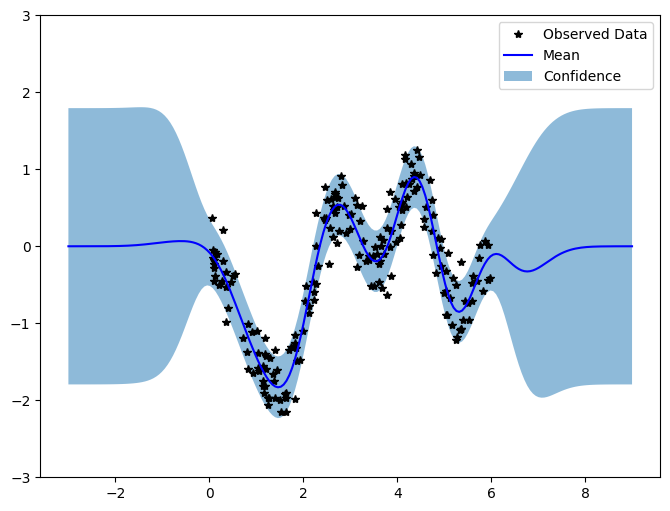

In [13]:
# Get into evaluation (predictive posterior) mode.

def plot_pred_dist_model(model, likelihood):

  model.eval()
  likelihood.eval()

  # Test points are regularly spaced along [-2, 8].
  # Make predictions for y by feeding model through likelihood.

  with torch.no_grad():
      test_x = torch.linspace(-3, 9, 200)
      predictions = likelihood(model(test_x))

  # We plot the predictive distribution (mean +- standard deviation).

  f, ax = plt.subplots(1, 1, figsize=(8, 6))
  lower, upper = predictions.confidence_region()
  ax.plot(x_train_snelson.numpy(), y_train_snelson.numpy(), 'k*')
  ax.plot(test_x.numpy(), predictions.mean.numpy(), 'b')
  ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
  ax.set_ylim([-3, 3])
  ax.legend(['Observed Data', 'Mean', 'Confidence'])
  return ax

plot_pred_dist_model(model_exact, model_exact.likelihood)


We now repeat this process for the approximate GP based on the Nyström approximation. In this case, depending on the randomly chosen points, you should see diverse results.

Iter 1/10 - Loss: 63.208756
Iter 2/10 - Loss: 60.736465
Iter 3/10 - Loss: 57.363007
Iter 4/10 - Loss: 57.256641
Iter 5/10 - Loss: 57.256202
Iter 6/10 - Loss: 57.256202
Iter 7/10 - Loss: 57.256202
Iter 8/10 - Loss: 57.256202
Iter 9/10 - Loss: 57.256202
Iter 10/10 - Loss: 57.256202


<Axes: >

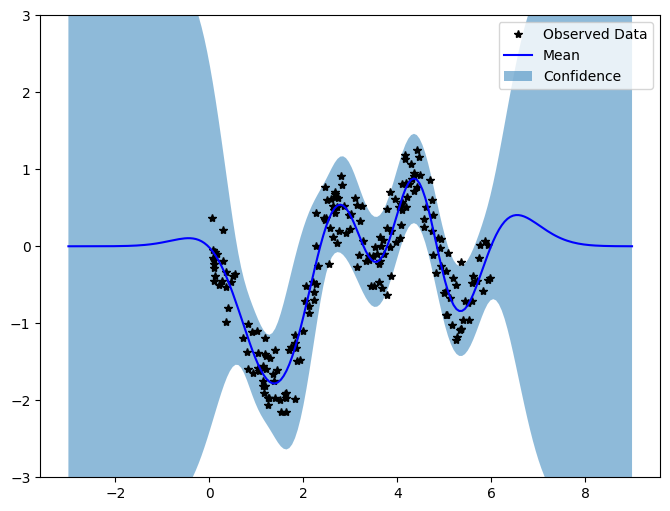

In [14]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

# We randomly choose M points from the training data

M = 10
N = x_train_snelson.shape[ 0 ]
random_points = x_train_snelson[ torch.randperm(x_train_snelson.shape[0])[0:M]]

model_nystrom = NystromSparseGPModel(x_train_snelson, y_train_snelson, random_points, likelihood)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_nystrom)

result = train_model(model_nystrom, mll, x_train_snelson, y_train_snelson)
plot_pred_dist_model(model_nystrom, likelihood)


## **Task 3**
Try runing the previous cell again to see the variability of the approximate predictive distribution when choosing different sets of random points to approximate the covariance matrix.


## **Sparse GPs via Random Features**

In this section we will use the random features approximation of the covariance matrix to speed-up GPs. This approximation is already included in gpytorch and we will only have to use the corresponding kernel.


 Instead of the shifted cosine features from Rahimi and Recht (2008), in gpytorch we use  the sine and cosine features which is a lower-variance estimator --- see    'On the Error of Random Fourier Features' by Sutherland and Schneider (2015).

By Bochner's theorem, any continuous kernel $k$ is positive definite
if and only if it is the Fourier transform of a non-negative measure $p(\omega)$, i.e.

$$
            k(x, x') = k(x - x') = \int p(\omega) e^{i(\omega^\top (x - x'))} d\omega.
        $$

where $p(\omega)$ is a normalized probability measure if $k(0)=1$.

For the RBF kernel,
$$
        k(\Delta) = \exp{(-\frac{\Delta^2}{2\sigma^2})}
$$
and
$$p(\omega) = \exp{(-\frac{\sigma^2\omega^2}{2})}$$

where $\Delta = x - x'$.

Given datapoint $x\in \mathbb{R}^d$, we can construct its random Fourier features $z(x) \in \mathbb{R}^{2D}$ by

  $$
        z(x) = \sqrt{\frac{1}{D}}
        \begin{bmatrix}
            \cos(\omega_1^\top x)\\
            \sin(\omega_1^\top x)\\
            \cdots \\
            \cos(\omega_D^\top x)\\
            \sin(\omega_D^\top x)
        \end{bmatrix}, \omega_1, \ldots, \omega_D \sim p(\omega)
      $$

such that we have an unbiased Monte Carlo estimator

 $$
            k(x, x') = k(x - x') \approx z(x)^\top z(x') = \frac{1}{D}\sum_{i=1}^D \cos(\omega_i^\top (x - x')).
   $$



In [15]:
# We define our approximate GP method based on the Random Features approximation

class RFSparseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, num_samples, likelihood):

        # We call the superclass with the training data and the associated likelihood.

        super(RFSparseGPModel, self).__init__(train_x, train_y, likelihood)

        # We consdier a constant mean equal to zero, which the typical case.

        self.mean_module = gpytorch.means.ZeroMean()

        # We consider a squared exponential (RBF) kernel with an amplitude (scale) parameter.
        # We use the kernel RRFKernel provided in Gpytorch. This kernel will compute
        # approximate covariances using random features.

        self.covar_module = gpytorch.kernels.RFFKernel(num_samples = num_samples)


    def forward(self, x):

        # The forwward method simply computes the prior means and covariances of the
        # process values associated to the input data.

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # We return a multivariate Gaussian distribution with the corresponding mean
        # and covariances.

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

That is it! We are now ready to use the previos object for regression with a faster computational cost than the exact GP method. We test its training time on the first dataset.

In [16]:
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

M = 50

model = RFSparseGPModel(train_x, train_y, M, likelihood)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

start = time.time()
result = train_model(model, mll, train_x, train_y)
end = time.time()

print("Total training time:", end - start)

Iter 1/10 - Loss: 147.768744
Iter 2/10 - Loss: -197.518721
Iter 3/10 - Loss: -197.877222
Iter 4/10 - Loss: -197.877513
Iter 5/10 - Loss: -197.877513
Iter 6/10 - Loss: -197.877513
Iter 7/10 - Loss: -197.877513
Iter 8/10 - Loss: -197.877513
Iter 9/10 - Loss: -197.877513
Iter 10/10 - Loss: -197.877513
Total training time: 0.10307765007019043


The training time should be much smaller than the standard full GP for M << N.

### **Predictive Distribution Visualization**

We use the dataset of Ed Snelson for the FITC approximation to check how the approximate predictive distribution looks like and how it compares to the exact one of the full GP.

<Axes: >

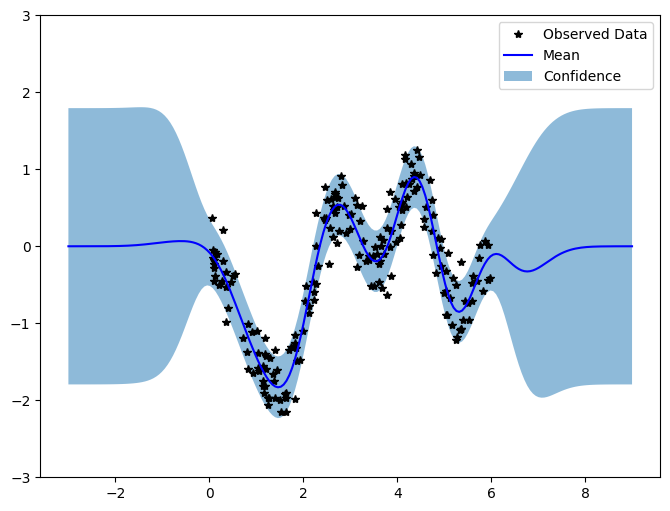

In [17]:
# First, the exact GP again.

plot_pred_dist_model(model_exact, model_exact.likelihood)


Now the RFSparse GP.

Iter 1/10 - Loss: 58.185120
Iter 2/10 - Loss: 55.766202
Iter 3/10 - Loss: 55.766155
Iter 4/10 - Loss: 55.766155
Iter 5/10 - Loss: 55.766155
Iter 6/10 - Loss: 55.766155
Iter 7/10 - Loss: 55.766155
Iter 8/10 - Loss: 55.766155
Iter 9/10 - Loss: 55.766155
Iter 10/10 - Loss: 55.766155


<Axes: >

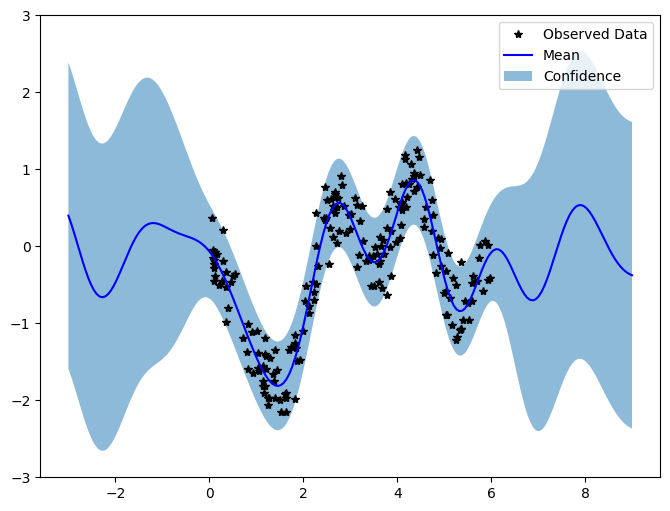

In [18]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

# We randomly choose M points from the training data

M = 100

model_rf = RFSparseGPModel(x_train_snelson, y_train_snelson, M, likelihood)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_rf)

result = train_model(model_rf, mll, x_train_snelson, y_train_snelson)
plot_pred_dist_model(model_rf, likelihood)

As you can see, it is possible to observe the wigglying effect that this approximation has on the approximate predictive distribution.

## **Task 4**

Try changing the value of M in the previous cell, i.e., the number of random features generated. You should observe that the approximate predictive distribution becomes closer and closer for larger and larger values of M. Try using M = 10, 50, 100, 200, 500, 1000, etc.

## **Sparse GPs via the FITC Approximation**


The FITC approximation of the covariance matrix to speed-up the computations of GPs is not directly implemented in GPytorch. However, it is very easy to extend the model to consider it. With this goal, we create a specific covariance function that will do the computations as indicated in the FITC approximation.

In [19]:
# Custom covairance function to implement the FITC approximation.
# This covariance function is equal to InducingPointKernel, but without
# adding extra regularization terms (Eq. 9 of Titsias 2009) to the MLL.

from gpytorch.lazy import LowRankRootAddedDiagLazyTensor, DiagLazyTensor

class FITCKernel(gpytorch.kernels.InducingPointKernel):

    def forward(self, x1, x2, diag=False, **kwargs):
      covar = self._get_covariance(x1, x2)

      if self.training:
        if not torch.equal(x1, x2):
                raise RuntimeError("x1 should equal x2 in training mode")

      if diag:
        return covar.diagonal(dim1=-1, dim2=-2)
      else:
        return covar

    def _get_covariance(self, x1, x2):

        covar = super(FITCKernel, self)._get_covariance(x1, x2)

        # We add diagonal correction if needed (only needed in training)
        # In test it is already added.

        if self.training == True and torch.equal(x1, x2):
            correction = (self.base_kernel(x1, x2, diag=True) - covar.diag()).clamp(0, math.inf)
            return LowRankRootAddedDiagLazyTensor(covar, DiagLazyTensor(correction))

        return covar


The previous kernel implementes the Nyström approximation to the covariances. Recall from what we have seen in the lectures that it is:
$$\Sigma = \Delta + \Sigma_{N,M}\Sigma_{M,M}^{-1}\Sigma_{N,M}$$, where $\Delta = diag(\Sigma) - diag(\Sigma_{N,M}\Sigma_{M,M}^{-1}\Sigma_{N,M})$.
Now, we can define our model. A standard GP using that particular covariance function.

In [20]:
# We define our approximate GP method based on the FITC approximation

class FITCSparseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, initial_inducing_points, likelihood):

        # We call the superclass with the training data and the associated likelihood.

        super(FITCSparseGPModel, self).__init__(train_x, train_y, likelihood)

        # We consdier a constant mean equal to zero, which the typical case.

        self.mean_module = gpytorch.means.ZeroMean()

        # We consider a squared exponential (RBF) kernel with an amplitude (scale) parameter.
        # We use the kernel InducingPointKernel provided in Gpytorch. This kernel will compute
        # approximate covariances as in the Nystrom approximation.

        self.covar_module = FITCKernel(\
              gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()), \
              initial_inducing_points, likelihood)


    def forward(self, x):

        # We add the diagonal correction of the FITC approximation

        gpytorch.settings.sgpr_diagonal_correction(True)

        # The forwward method simply computes the prior means and covariances of the
        # process values associated to the input data.

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # We return a multivariate Gaussian distribution with the corresponding mean
        # and covariances.

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

That is it! We are now ready to use the previos object for regression with a faster computational cost than the exact GP method. We test it on the first dataset considered and measure traning time. In this case, the inducing points will be optimized.

In [21]:
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

# We randomly choose M points from the training data as the inducing points

M = 100
inducing_points = train_x[ torch.randperm(N)[0:M]]

model = FITCSparseGPModel(train_x, train_y, inducing_points, likelihood)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

start = time.time()
result = train_model(model, mll, train_x, train_y)
end = time.time()

print("Total training time:", end - start)

Iter 1/10 - Loss: 347.054323
Iter 2/10 - Loss: -191.997752


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 3/10 - Loss: -196.324718
Iter 4/10 - Loss: -196.695427
Iter 5/10 - Loss: -196.768508
Iter 6/10 - Loss: -197.032312
Iter 7/10 - Loss: -197.135348
Iter 8/10 - Loss: -197.181715
Iter 9/10 - Loss: -197.189384
Iter 10/10 - Loss: -197.198663
Total training time: 0.393873929977417


The traning time should be much smaller than that of the full GP for $M <<N$.

### **Predictive Distribution Visualization**

We use the dataset of Ed Snelson for the FITC approximation to check how the approximate predictive distribution looks like and how it compares to the exact one of the full GP.

<Axes: >

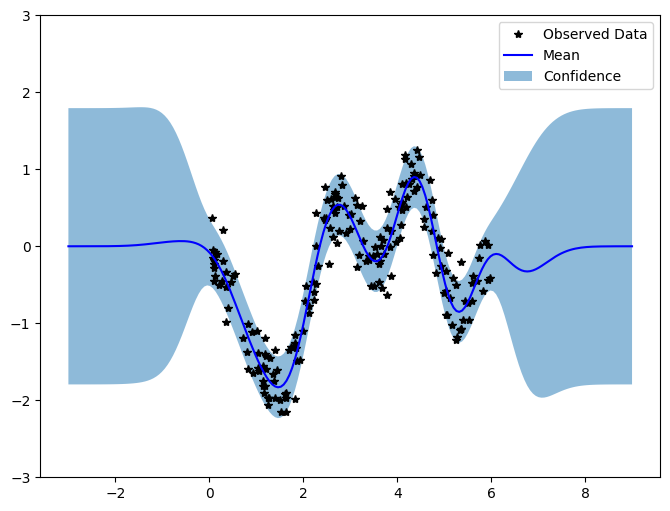

In [22]:
# First, the exact GP again.

plot_pred_dist_model(model_exact, model_exact.likelihood)

Now the FITC sparse GP.

Iter 1/25 - Loss: 59.297462
Iter 2/25 - Loss: 54.093829
Iter 3/25 - Loss: 53.452158
Iter 4/25 - Loss: 52.495004
Iter 5/25 - Loss: 52.244046
Iter 6/25 - Loss: 52.159955
Iter 7/25 - Loss: 52.151464
Iter 8/25 - Loss: 51.879421
Iter 9/25 - Loss: 51.387767
Iter 10/25 - Loss: 51.362265
Iter 11/25 - Loss: 51.361341
Iter 12/25 - Loss: 51.360195
Iter 13/25 - Loss: 51.356417
Iter 14/25 - Loss: 51.320135
Iter 15/25 - Loss: 51.306145
Iter 16/25 - Loss: 51.304197
Iter 17/25 - Loss: 51.303630
Iter 18/25 - Loss: 51.302961
Iter 19/25 - Loss: 51.302889
Iter 20/25 - Loss: 51.302634
Iter 21/25 - Loss: 51.302461
Iter 22/25 - Loss: 51.302269
Iter 23/25 - Loss: 51.302269
Iter 24/25 - Loss: 51.302269
Iter 25/25 - Loss: 51.302269


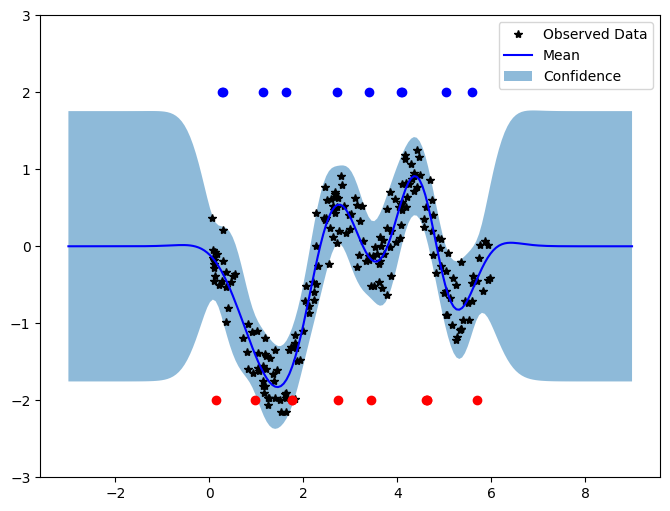

In [23]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

# We randomly choose M points from the training data

M = 10
inducing_points = x_train_snelson[ torch.randperm(x_train_snelson.shape[ 0 ])[0:M]]
#inducing_points = torch.linspace(1, 2, M)
initial_inducing_points = torch.ones(inducing_points.shape) * inducing_points

model_fitc = FITCSparseGPModel(x_train_snelson, y_train_snelson, inducing_points, likelihood)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_fitc)

result = train_model(model_fitc, mll, x_train_snelson, y_train_snelson, training_iter = 25)

ax = plot_pred_dist_model(model_fitc, likelihood)

# We plot the iniital inducing points on top in blue and at the
# optimized inducing points at the bottom in red.

with torch.no_grad():
  ax.plot(initial_inducing_points, torch.ones(M).numpy() * 2, "bo")
  ax.plot(model_fitc.covar_module.inducing_points, torch.ones(M).numpy() * -2, "ro")


## **Task 5**

Try to choose and adversarial initialization of the induicng points and see how they are spread over the input space after optimization. For example, you can place the inducing points un the interval [1,2]. Use torch.linspace(1,2,M) for that.

## **Sparse GPs via the VFE approach**

In this section we try to use in practice the sparse GP approximation based on the variational free energy. This approximation is already implemented in gpytorch, so we do not have to introduce extra code at all.

In [24]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy

# We define our approximate GP method based on the VFE approach

class VFESparseGP(ApproximateGP):
    def __init__(self, inducing_points):

        # We use a zero mean and an RBF kernel

        mean_module = gpytorch.means.ZeroMean()
        covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        # We use a cholesky factorization to represent the parameters of the
        # variational approximate distribution q

        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0), mean_init_std=0.0)

        # We initialize the variational distribution

        init_dist = gpytorch.distributions.MultivariateNormal(torch.zeros(inducing_points.size(0)), \
            covar_module(inducing_points) * 1e-5)

        variational_distribution.initialize_variational_distribution(init_dist)

        # We use an unwhitened variational strategy. Whitening is also possible and
        # described later on.

        variational_strategy = UnwhitenedVariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        variational_strategy.variational_params_initialized = torch.tensor(1) # XXX DHL This avoids random initialization

        super(VFESparseGP, self).__init__(variational_strategy)

        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

We can now create the model and the likelihood. To train this model we no longer can use the marginal likelhood. We will have to use the ELBO given by variational inference.

In [25]:
from gpytorch.mlls import VariationalELBO
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

M = 100
inducing_points = train_x[ 0 : M ]
model = VFESparseGP(inducing_points)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0))

start = time.time()
result_unwhitened = train_model(model, mll, train_x, train_y, 500, likelihood)
end = time.time()

print("Total training time:", end - start)

Iter 1/500 - Loss: 2852.685243
Iter 2/500 - Loss: 2035.041690
Iter 3/500 - Loss: 2018.448028
Iter 4/500 - Loss: 1942.661105
Iter 5/500 - Loss: 1872.820200
Iter 6/500 - Loss: 1755.250162
Iter 7/500 - Loss: 1699.784431
Iter 8/500 - Loss: 1598.223932
Iter 9/500 - Loss: 1480.860019
Iter 10/500 - Loss: 1312.086995
Iter 11/500 - Loss: 1248.197720
Iter 12/500 - Loss: 1157.837247
Iter 13/500 - Loss: 1072.925687
Iter 14/500 - Loss: 1030.055348
Iter 15/500 - Loss: 978.894730
Iter 16/500 - Loss: 957.114325
Iter 17/500 - Loss: 934.930470
Iter 18/500 - Loss: 920.422454
Iter 19/500 - Loss: 903.446923
Iter 20/500 - Loss: 879.942067
Iter 21/500 - Loss: 859.000249
Iter 22/500 - Loss: 837.760426
Iter 23/500 - Loss: 814.523244
Iter 24/500 - Loss: 795.233720
Iter 25/500 - Loss: 784.101352
Iter 26/500 - Loss: 774.143739
Iter 27/500 - Loss: 765.030353
Iter 28/500 - Loss: 753.166836
Iter 29/500 - Loss: 739.278687
Iter 30/500 - Loss: 728.510803
Iter 31/500 - Loss: 716.983431
Iter 32/500 - Loss: 704.152851
Ite

The training time should be faster than that of a full GP for $M << N$. However, due to the strong dependencies of the prior, fitting the variational distribution may take long. Later on, we will see how speed-up this process. Furthermore, note that in the batch_optimization case (i.e., when no mini-batch training is used) it is possible to derive the optimal parameters of $q$, which will speed-up the training process sinificantly. For simplicity, we do not consider that approach here. However, gpytorch also provides support for it.

### **Predictive Distribution**

We use the dataset of Ed Snelson for the VFE approximation to check how the approximate predictive distribution looks like and how it compares to the exact one of the full GP.

<Axes: >

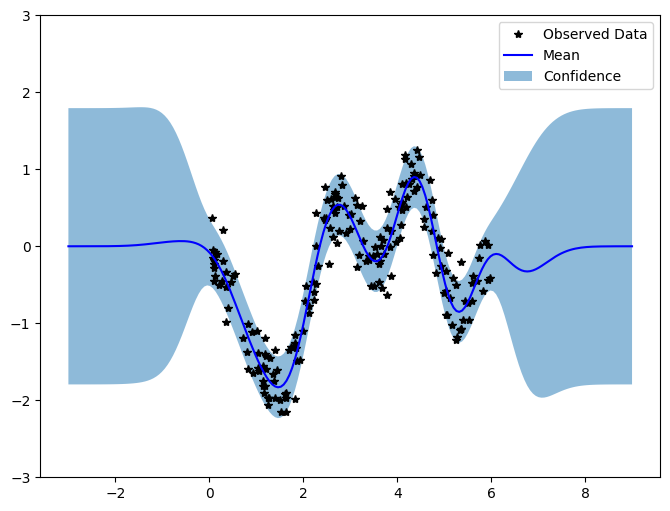

In [26]:
# First, the exact GP again.

plot_pred_dist_model(model_exact, model_exact.likelihood)

Now the VFE Sparse GP.

Iter 1/100 - Loss: 8254.301967
Iter 2/100 - Loss: 3719.670050
Iter 3/100 - Loss: 3459.101748
Iter 4/100 - Loss: 2762.694289
Iter 5/100 - Loss: 2059.937851
Iter 6/100 - Loss: 1311.838491
Iter 7/100 - Loss: 1020.428417
Iter 8/100 - Loss: 864.554611
Iter 9/100 - Loss: 804.218975
Iter 10/100 - Loss: 699.005062
Iter 11/100 - Loss: 576.847870
Iter 12/100 - Loss: 553.423468
Iter 13/100 - Loss: 457.214803
Iter 14/100 - Loss: 394.496199
Iter 15/100 - Loss: 279.274722
Iter 16/100 - Loss: 236.762843
Iter 17/100 - Loss: 193.181956
Iter 18/100 - Loss: 177.453653
Iter 19/100 - Loss: 159.138785
Iter 20/100 - Loss: 147.049324
Iter 21/100 - Loss: 136.702028
Iter 22/100 - Loss: 131.524746
Iter 23/100 - Loss: 125.717401
Iter 24/100 - Loss: 124.676257
Iter 25/100 - Loss: 123.366397
Iter 26/100 - Loss: 121.153267
Iter 27/100 - Loss: 117.328235
Iter 28/100 - Loss: 114.068403
Iter 29/100 - Loss: 110.002921
Iter 30/100 - Loss: 102.921069
Iter 31/100 - Loss: 99.671807
Iter 32/100 - Loss: 94.673874
Iter 33/100 

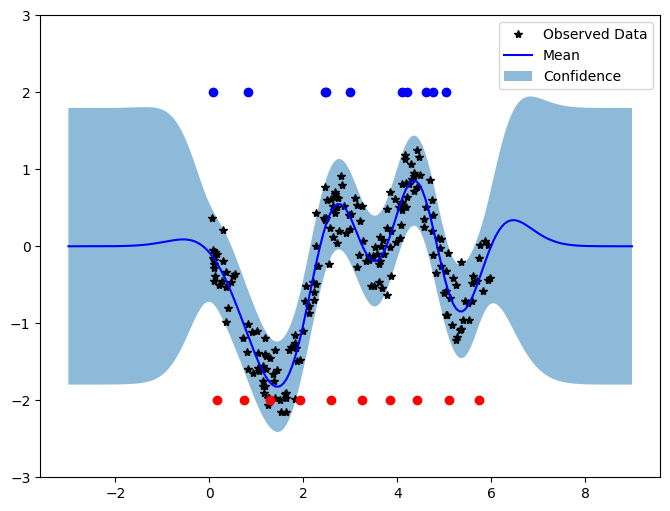

In [27]:
from gpytorch.mlls import VariationalELBO

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.01

# We specify the initial inducing points locations

M = 10
inducing_points = x_train_snelson[ torch.randperm(x_train_snelson.shape[ 0 ])[0:M]]
#inducing_points = torch.linspace(1, 2, M)
initial_inducing_points = torch.ones(inducing_points.shape) * inducing_points

# We create the model and the VFE objective

model_vfe = VFESparseGP(inducing_points)

mll = gpytorch.mlls.VariationalELBO(likelihood, model_vfe, num_data=x_train_snelson.size(0))

# We train the model

result = train_model(model_vfe, mll, x_train_snelson, y_train_snelson, 100, likelihood)

# We plot the predictive distribution

ax = plot_pred_dist_model(model_vfe, likelihood)

# We plot the iniital inducing points on top in blue and at the
# optimized inducing points at the bottom in red.

with torch.no_grad():
  ax.plot(initial_inducing_points, torch.ones(M).numpy() * 2, "bo")
  ax.plot(model_vfe.variational_strategy.inducing_points, torch.ones(M).numpy() * -2, "ro")



## **Task 6**

Try to choose and adversarial initialization of the induicng points and see how they are spread over the input space after optimization. For example, you can place the inducing points un the interval [1,2]. Use torch.linspace(1,2,M) for that.

## **Improving VFE Method by Whitening**

In this section we consdier a whitened approximate distribution $q$ for the VFE method. For that, we simply replace the approximate distribution by UnwhitenedVariationalStrategy by VariationalStrategy.

In [28]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

# We define our approximate GP method based on the VFE approach

class VFESparseGP(ApproximateGP):
    def __init__(self, inducing_points):

        # We use a zero mean and an RBF kernel

        mean_module = gpytorch.means.ZeroMean()
        covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        # We use a cholesky factorization to represent the parameters of the
        # variational approximate distribution q

        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0), mean_init_std=0.0)

        # We initialize the variational distribution

        init_dist = gpytorch.distributions.MultivariateNormal(torch.zeros(inducing_points.size(0)), \
            torch.eye(inducing_points.size(0)) * 1e-5)

        variational_distribution.initialize_variational_distribution(init_dist)

        # We use a whitened variational strategy (default)

        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        variational_strategy.variational_params_initialized = torch.tensor(1) # XXX DHL This avoids random initialization

        super(VFESparseGP, self).__init__(variational_strategy)

        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

We can now create the model and the likelihood. To train this model we no longer can use the marginal likelhood. We will have to use the ELBO given by variational inference.

In [29]:
from gpytorch.mlls import VariationalELBO
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

M = 100
inducing_points = train_x[ 0 : M ]
model = VFESparseGP(inducing_points)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0))

start = time.time()
result_whitened = train_model(model, mll, train_x, train_y, 500, likelihood)
end = time.time()

print("Total training time:", end - start)

Iter 1/500 - Loss: 3188.410532
Iter 2/500 - Loss: 1312.117691
Iter 3/500 - Loss: 1036.334097
Iter 4/500 - Loss: 938.931737
Iter 5/500 - Loss: 850.253656
Iter 6/500 - Loss: 806.879893
Iter 7/500 - Loss: 745.860265
Iter 8/500 - Loss: 693.540624
Iter 9/500 - Loss: 661.899234
Iter 10/500 - Loss: 627.922033
Iter 11/500 - Loss: 608.343832
Iter 12/500 - Loss: 589.446052
Iter 13/500 - Loss: 485.272448
Iter 14/500 - Loss: 434.798136
Iter 15/500 - Loss: 417.421957
Iter 16/500 - Loss: 388.580666
Iter 17/500 - Loss: 361.201302
Iter 18/500 - Loss: 338.747069
Iter 19/500 - Loss: 312.021048
Iter 20/500 - Loss: 265.467989
Iter 21/500 - Loss: 174.002359
Iter 22/500 - Loss: 150.922727
Iter 23/500 - Loss: 114.811562
Iter 24/500 - Loss: 71.587563
Iter 25/500 - Loss: 58.070239
Iter 26/500 - Loss: 49.614315
Iter 27/500 - Loss: 36.655799
Iter 28/500 - Loss: 33.815381
Iter 29/500 - Loss: 26.090252
Iter 30/500 - Loss: 16.230293
Iter 31/500 - Loss: 12.405379
Iter 32/500 - Loss: 8.657605
Iter 33/500 - Loss: -4.4

As you can see using a Whitened Variational Distribution helps in the optimization process. In particular, better values for the objective are obtained with a smaller number of iterations. That is why it is the default variational approximation in gpytorch.

/tmp/ipykernel_163564/51931658.py:3: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(np.arange(0,500)), result_unwhitened.numpy(), 'r')
/tmp/ipykernel_163564/51931658.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(np.arange(0,500)), result_whitened.numpy(),'b')


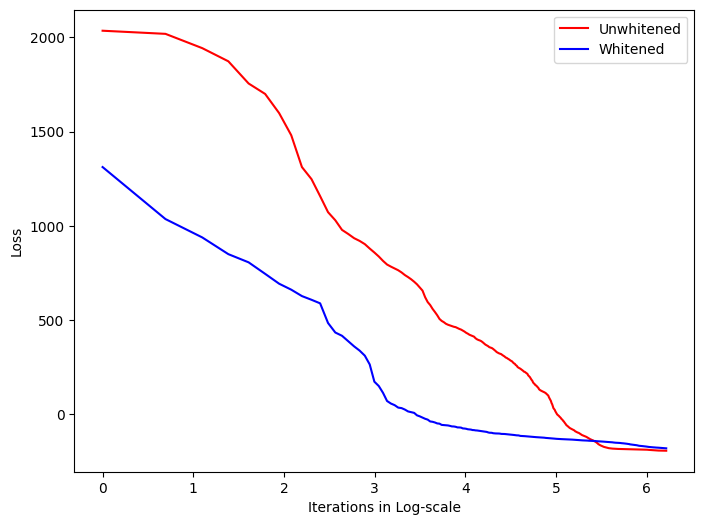

In [30]:
  f, ax = plt.subplots(1, 1, figsize=(8, 6))
  with torch.no_grad():
    ax.plot(np.log(np.arange(0,500)), result_unwhitened.numpy(), 'r')
    ax.plot(np.log(np.arange(0,500)), result_whitened.numpy(),'b')
  ax.set_xlabel("Iterations in Log-scale")
  ax.set_ylabel("Loss")
  ax.legend(['Unwhitened', 'Whitened'])

## **Natural Gradients**

In this section we explore the utility of natural gradients for optimizing the variational distribution. We will use a standard ADAM optimizer instead of L-BFGS to better see the differences in optimization by changing the gradients for $q$. We consider a whitened variational distribution.

First we train the method using ADAM and standard gradients.

In [31]:
def train_model_ADAM(model, mll, train_x, train_y, training_iter = 10, likelihood = None):

  model.train()
  losses = torch.zeros(training_iter)

  # we instantiate the ADAM optimizer, which will optimize the hyper-parameters.

  if likelihood is None:
    parameters = model.parameters()
  else:
    parameters = list(model.parameters()) + list(likelihood.parameters())

  optimizer = torch.optim.Adam(parameters, lr = 0.01)

  def closure():
      optimizer.zero_grad()
      output = model(train_x)
      loss = -mll(output, train_y)
      loss.backward()
      return loss

  for i in range(training_iter):

    loss = closure() * train_x.shape[ 0 ]
    print('Iter %d/%d - Loss: %f' % (i + 1, training_iter, loss.item()))
    losses[ i ] = torch.from_numpy(np.array([loss.item()]))

    optimizer.step(closure)

  return losses

We do now the actual training.

In [32]:
from gpytorch.mlls import VariationalELBO
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

M = 100
inducing_points = train_x[ 0 : M ]
model = VFESparseGP(inducing_points)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0))

start = time.time()
result_standard_gradients = train_model_ADAM(model, mll, train_x, train_y, 500, likelihood)
end = time.time()

print("Total training time:", end - start)

Iter 1/500 - Loss: 3188.410532
Iter 2/500 - Loss: 2971.273718
Iter 3/500 - Loss: 2801.469009
Iter 4/500 - Loss: 2683.295405
Iter 5/500 - Loss: 2551.459403
Iter 6/500 - Loss: 2427.012726
Iter 7/500 - Loss: 2317.283064
Iter 8/500 - Loss: 2211.941494
Iter 9/500 - Loss: 2116.166521
Iter 10/500 - Loss: 2047.923496
Iter 11/500 - Loss: 1964.897627
Iter 12/500 - Loss: 1896.038291
Iter 13/500 - Loss: 1834.076530
Iter 14/500 - Loss: 1777.439968
Iter 15/500 - Loss: 1725.018258
Iter 16/500 - Loss: 1676.184900
Iter 17/500 - Loss: 1630.348722
Iter 18/500 - Loss: 1587.533100
Iter 19/500 - Loss: 1547.717563
Iter 20/500 - Loss: 1511.030451
Iter 21/500 - Loss: 1477.363794
Iter 22/500 - Loss: 1445.885386
Iter 23/500 - Loss: 1415.322587
Iter 24/500 - Loss: 1384.462661
Iter 25/500 - Loss: 1352.703471
Iter 26/500 - Loss: 1321.735150
Iter 27/500 - Loss: 1294.212764
Iter 28/500 - Loss: 1268.390966
Iter 29/500 - Loss: 1242.424234
Iter 30/500 - Loss: 1217.070637
Iter 31/500 - Loss: 1192.661942
Iter 32/500 - Los

The first step towards using natural gradients is defining a NaturalVariational distribution. Therefore, we have to re-define the model.

In [33]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import NaturalVariationalDistribution
from gpytorch.variational import VariationalStrategy

# We define our approximate GP method based on the VFE approach

class NaturalVFESparseGP(ApproximateGP):
    def __init__(self, inducing_points):

        # We use a zero mean and an RBF kernel

        mean_module = gpytorch.means.ZeroMean()
        covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        # We use a cholesky factorization to represent the parameters of the
        # variational approximate distribution q

        variational_distribution = NaturalVariationalDistribution(inducing_points.size(0), mean_init_std=0.0)

        # We initialize the variational distribution

        init_dist = gpytorch.distributions.MultivariateNormal(torch.zeros(inducing_points.size(0)), \
            torch.eye(inducing_points.size(0)) * 1e-5)

        variational_distribution.initialize_variational_distribution(init_dist)

        # We use a whitened variational strategy.

        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        variational_strategy.variational_params_initialized = torch.tensor(1) # XXX DHL This avoids random initialization

        super(NaturalVFESparseGP, self).__init__(variational_strategy)

        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Now we define a separate optimizer for the parameters related to the variational distribuiton. This optimizer will use natural gradients.

In [34]:
def train_model_NaturalGradients(model, mll, train_x, train_y, training_iter = 10, likelihood = None):

  model.train()
  losses = torch.zeros(training_iter)

  # We instantiate the LBFGS optimizer, which will optimize the hyper-parameters.

  if likelihood is None:
    parameters = model.hyperparameters()
  else:
    parameters = list(model.hyperparameters()) + list(likelihood.parameters())

  optimizer = torch.optim.Adam(parameters, lr = 0.01)

  # We instantiate the NGD optimizer, which will optimize the variational distribution q.
  # This optimizer allows to have larger learning rates.

  variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), \
      num_data=train_y.size(0), lr=1.0)

  def closure():
      optimizer.zero_grad()
      variational_ngd_optimizer.zero_grad()
      output = model(train_x)
      loss = -mll(output, train_y)
      loss.backward()
      return loss

  for i in range(training_iter):

    loss = closure() * train_x.shape[ 0 ]
    print('Iter %d/%d - Loss: %f' % (i + 1, training_iter, loss.item()))
    losses[ i ] = torch.from_numpy(np.array([loss.item()]))

    # We update each parameter group according to each optimizer

    optimizer.step()
    variational_ngd_optimizer.step()

  return losses

We do now the actual training using natural gradients.

In [35]:
from gpytorch.mlls import VariationalELBO
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

M = 100
inducing_points = train_x[ 0 : M ]
model = NaturalVFESparseGP(inducing_points)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0))

start = time.time()
result_natural_gradients = train_model_NaturalGradients(model, mll, train_x, train_y, 500, likelihood)
end = time.time()

print("Total training time:", end - start)

Iter 1/500 - Loss: 3188.410532
Iter 2/500 - Loss: 5763.046444
Iter 3/500 - Loss: 2427.722490
Iter 4/500 - Loss: 1590.045730
Iter 5/500 - Loss: 819.906120
Iter 6/500 - Loss: 767.524996
Iter 7/500 - Loss: 730.130315
Iter 8/500 - Loss: 703.241210
Iter 9/500 - Loss: 682.383747
Iter 10/500 - Loss: 665.454749
Iter 11/500 - Loss: 651.014905
Iter 12/500 - Loss: 638.303158
Iter 13/500 - Loss: 626.894668
Iter 14/500 - Loss: 616.517815
Iter 15/500 - Loss: 606.980746
Iter 16/500 - Loss: 598.140255
Iter 17/500 - Loss: 589.885959
Iter 18/500 - Loss: 582.130774
Iter 19/500 - Loss: 574.804604
Iter 20/500 - Loss: 567.849944
Iter 21/500 - Loss: 561.218721
Iter 22/500 - Loss: 554.869979
Iter 23/500 - Loss: 548.768165
Iter 24/500 - Loss: 542.881887
Iter 25/500 - Loss: 537.183001
Iter 26/500 - Loss: 531.645947
Iter 27/500 - Loss: 526.247259
Iter 28/500 - Loss: 520.965174
Iter 29/500 - Loss: 515.779301
Iter 30/500 - Loss: 510.670312
Iter 31/500 - Loss: 505.619624
Iter 32/500 - Loss: 500.609075
Iter 33/500 -

We now plot the optimization results of each method.

/tmp/ipykernel_163564/1257503023.py:3: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(np.arange(0,500)), result_standard_gradients.numpy(), 'r')
/tmp/ipykernel_163564/1257503023.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(np.arange(0,500)), result_natural_gradients.numpy(),'b')


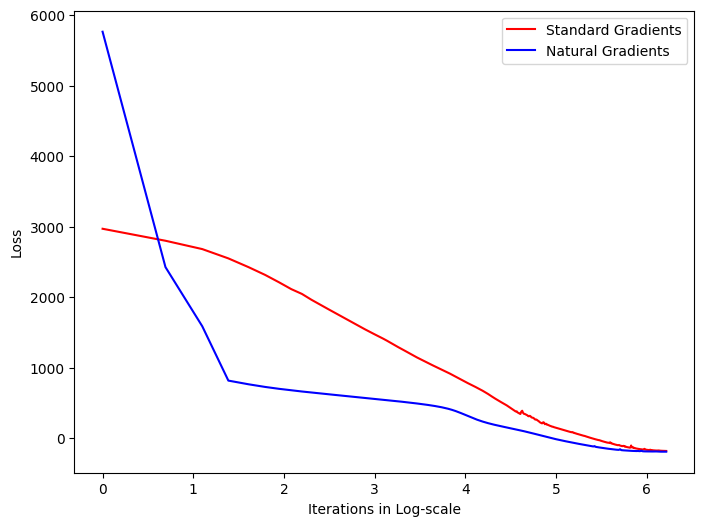

In [36]:
f, ax = plt.subplots(1, 1, figsize=(8, 6))
with torch.no_grad():
    ax.plot(np.log(np.arange(0,500)), result_standard_gradients.numpy(), 'r')
    ax.plot(np.log(np.arange(0,500)), result_natural_gradients.numpy(),'b')
ax.set_xlabel("Iterations in Log-scale")
ax.set_ylabel("Loss")
ax.legend(['Standard Gradients', 'Natural Gradients'])

## **Training Using Mini-batches**

We now show that the VFE method allows for training using mini-batches. This means that we can update the model parameters without having to go through all the data. In this way, the training cost will no longer depende on the number of training instances, assuming a constant number of interations until convergence. To test this, we consider the first toy dataset described in this notebook and report the loss of a batch-method and the loss of a method using mini-batches, as a function of the number of mini-batches processed.


In [37]:
# We consdier 1000 instances

N = 1000

# Training data are N points regularly spaced in the interval [0,1].

train_x = torch.linspace(0, 1, N)

# True function is sin(2*pi*x) with additive Gaussian noise with variance 0.04.

train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

We now define a training method that considers minibatches.

In [38]:
from torch.utils.data import TensorDataset, DataLoader

def train_model_ADAM_mini_batches(model, mll, train_x, train_y, training_iter = 10, \
      batch_size = 100, likelihood = None):

  model.train()
  losses = torch.zeros(training_iter * int(train_x.shape[ 0 ] / batch_size))

  # we instantiate the ADAM optimizer, which will optimize the hyper-parameters.

  if likelihood is None:
    parameters = model.parameters()
  else:
    parameters = list(model.parameters()) + list(likelihood.parameters())

  optimizer = torch.optim.Adam(parameters, lr = 0.01)

  train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=batch_size, shuffle=True)

  def closure(mini_batch_x, mini_batch_y):
      optimizer.zero_grad()
      output = model(mini_batch_x)
      loss = -mll(output, mini_batch_y)
      loss.backward()
      return loss

  # We loop through the number of iterations (epochs)

  for i in range(training_iter):

    # We loop through the mini_batches

    j = 0
    for (x_batch, y_batch) in train_loader:

      loss = closure(x_batch, y_batch) * train_x.shape[ 0 ]
      print('Iter %d/%d - Loss: %f' % (i + 1, training_iter, loss.item()))
      losses[ i * int(train_x.shape[ 0 ] / batch_size) + j ] = torch.from_numpy(np.array([loss.item()]))
      optimizer.step()
      j += 1

  return losses

We train the method using mini-batches for a total of 100 iterations through the data. That is, 100 epochs.

In [39]:
from gpytorch.mlls import VariationalELBO
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

M = 100
inducing_points = train_x[ 0 : M ]
model = VFESparseGP(inducing_points)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0))

num_epochs = 100
mini_batch_size = 100

start = time.time()
result_mini_batches = train_model_ADAM_mini_batches(model, mll, train_x, train_y, num_epochs, mini_batch_size, likelihood)
end = time.time()

print("Total training time:", end - start)

Iter 1/100 - Loss: 2847.395744
Iter 1/100 - Loss: 3045.049914
Iter 1/100 - Loss: 2747.733181
Iter 1/100 - Loss: 2437.540822
Iter 1/100 - Loss: 2635.944823
Iter 1/100 - Loss: 2523.254459
Iter 1/100 - Loss: 2171.978987
Iter 1/100 - Loss: 2482.898237
Iter 1/100 - Loss: 2213.135017
Iter 1/100 - Loss: 1957.553246
Iter 2/100 - Loss: 2100.936104
Iter 2/100 - Loss: 1788.821211
Iter 2/100 - Loss: 1757.880592
Iter 2/100 - Loss: 1693.855594
Iter 2/100 - Loss: 1881.341013
Iter 2/100 - Loss: 1728.304634
Iter 2/100 - Loss: 1545.033997
Iter 2/100 - Loss: 1485.276407
Iter 2/100 - Loss: 1560.703712
Iter 2/100 - Loss: 1430.152725
Iter 3/100 - Loss: 1643.157798
Iter 3/100 - Loss: 1368.523300
Iter 3/100 - Loss: 1343.136330
Iter 3/100 - Loss: 1505.861734
Iter 3/100 - Loss: 1294.253071
Iter 3/100 - Loss: 1354.190241
Iter 3/100 - Loss: 1156.733761
Iter 3/100 - Loss: 1146.961433
Iter 3/100 - Loss: 1209.894069
Iter 3/100 - Loss: 1305.500560
Iter 4/100 - Loss: 1369.584971
Iter 4/100 - Loss: 1041.784969
Iter 4/1

We train the method using all data for a total of 100 iterations.

In [40]:
from gpytorch.mlls import VariationalELBO
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

M = 100
inducing_points = train_x[ 0 : M ]
model = VFESparseGP(inducing_points)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0))

num_epochs = 100

start = time.time()
result_all_data = train_model_ADAM_mini_batches(model, mll, train_x, train_y, num_epochs, train_x.shape[ 0 ], likelihood)
end = time.time()

print("Total training time:", end - start)

Iter 1/100 - Loss: 3172.414263
Iter 2/100 - Loss: 2953.560402
Iter 3/100 - Loss: 2781.572254
Iter 4/100 - Loss: 2666.123919
Iter 5/100 - Loss: 2535.317158
Iter 6/100 - Loss: 2411.188810
Iter 7/100 - Loss: 2293.062734
Iter 8/100 - Loss: 2187.746220
Iter 9/100 - Loss: 2092.503160
Iter 10/100 - Loss: 2004.953341
Iter 11/100 - Loss: 1924.075344
Iter 12/100 - Loss: 1855.769790
Iter 13/100 - Loss: 1788.071519
Iter 14/100 - Loss: 1731.664394
Iter 15/100 - Loss: 1681.500536
Iter 16/100 - Loss: 1631.280974
Iter 17/100 - Loss: 1589.164818
Iter 18/100 - Loss: 1552.030839
Iter 19/100 - Loss: 1515.668490
Iter 20/100 - Loss: 1481.885756
Iter 21/100 - Loss: 1451.071318
Iter 22/100 - Loss: 1419.239144
Iter 23/100 - Loss: 1388.240254
Iter 24/100 - Loss: 1357.923103
Iter 25/100 - Loss: 1330.034955
Iter 26/100 - Loss: 1301.424084
Iter 27/100 - Loss: 1275.338010
Iter 28/100 - Loss: 1249.030989
Iter 29/100 - Loss: 1224.934512
Iter 30/100 - Loss: 1200.178962
Iter 31/100 - Loss: 1178.432814
Iter 32/100 - Los

We plot the performance of each method as a function of the number of instances processed.

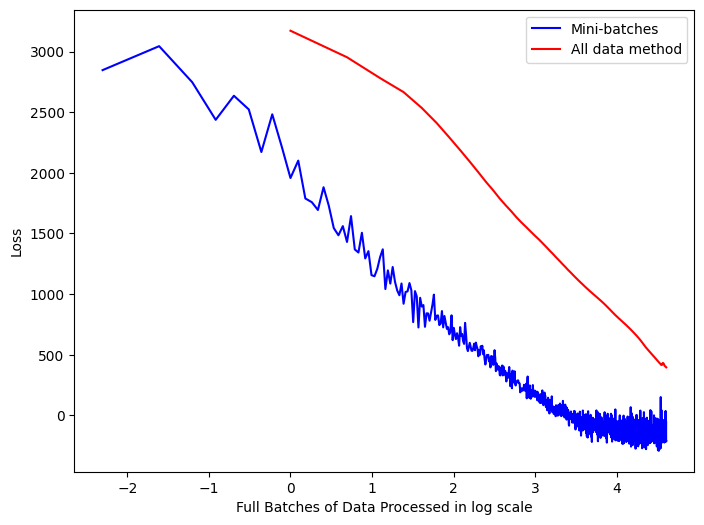

In [41]:
input_all_data = ((np.arange(0, result_all_data.shape[ 0 ]) + 1) * train_x.shape[ 0 ]) / train_x.shape[ 0 ]
input_mini_batches = (np.arange(0, result_mini_batches.shape[0]) + 1)* mini_batch_size / train_x.shape[ 0 ]

f, ax = plt.subplots(1, 1, figsize=(8, 6))
with torch.no_grad():
    ax.plot(np.log(input_mini_batches), result_mini_batches.numpy(), 'b')
    ax.plot(np.log(input_all_data), result_all_data.numpy(),'r')
ax.set_xlabel("Full Batches of Data Processed in log scale")
ax.set_ylabel("Loss")
ax.legend(['Mini-batches', 'All data method'])

## **VFE Sparse GP for Classification**

In this part of the notebook we illustrate how to use the sparse VFE GP to address classification problems. In this case, the likelihood that we will use the CDF of the standard Gaussian distribution as the activation function. The required expectation of the data-dependent terms of the ELBO, e.g., $E_q[\log p(y_i|f(x_i))]$, are intractable, but they are approximated in gpytorch by quadrature.

We generate first some synthetic data in a two dimensional space. The problem considered is the XOR problem, which is non-linear.

In [42]:
# We generate random data uniformly in the unit box with a fixed random seed.

n_train = 200

torch.random.manual_seed(0)

x1 = torch.rand(n_train, 1) - 0.5
x2 = torch.rand(n_train,1) - 0.5

# We define the target function which generates the class label.

data_fn = lambda x1, x2: (torch.sign(torch.sign(x1) * torch.sign(x2)) + 1.0) * 0.5

# We generate the observed data.

latent_fn = data_fn(x1, x2)
train_y_c = torch.round(latent_fn).long().squeeze()
train_x_c = torch.cat((x1, x2),dim=1)
color = np.array(["red", "blue"])[ train_y_c.numpy() ]
train_y_c = train_y_c.float()

We now plot the data for visualization.

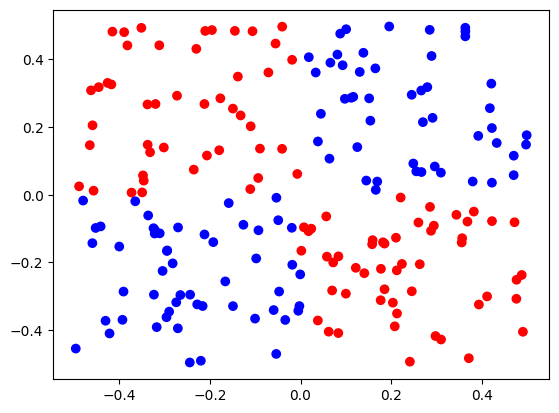

In [43]:
plt.scatter(train_x_c[:,0].numpy(), train_x_c[:,1].numpy(), c = color)


We are now ready to define the GP method.

In [44]:
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

# We choose the inducing points

M = 10
inducing_points = train_x_c[ 0 : M, : ]
#ind_x1 = torch.rand(M, 1) * 0.2 + 0.5
#ind_x2 = torch.rand(M, 1) * 0.2 + 0.5
#inducing_points = torch.cat((ind_x1, ind_x2),dim=1)


initial_inducing_points = torch.ones(inducing_points.shape) * inducing_points

# We create the model and the objective

model = VFESparseGP(inducing_points)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x_c.size(0))

# We train the model

start = time.time()
result_natural_gradients = train_model(model, mll, train_x_c, train_y_c, 500, likelihood)
end = time.time()

print("Total training time:", end - start)

Iter 1/500 - Loss: 191.313345
Iter 2/500 - Loss: 146.602035
Iter 3/500 - Loss: 109.244244
Iter 4/500 - Loss: 96.183835
Iter 5/500 - Loss: 93.292673
Iter 6/500 - Loss: 89.385539
Iter 7/500 - Loss: 88.693572
Iter 8/500 - Loss: 88.149180
Iter 9/500 - Loss: 87.264130
Iter 10/500 - Loss: 87.134690
Iter 11/500 - Loss: 85.649539
Iter 12/500 - Loss: 83.477357
Iter 13/500 - Loss: 76.711937
Iter 14/500 - Loss: 72.967513
Iter 15/500 - Loss: 70.173731
Iter 16/500 - Loss: 67.915847
Iter 17/500 - Loss: 65.532498
Iter 18/500 - Loss: 64.527234
Iter 19/500 - Loss: 62.549835
Iter 20/500 - Loss: 62.084243
Iter 21/500 - Loss: 61.848086
Iter 22/500 - Loss: 61.183649
Iter 23/500 - Loss: 60.046245
Iter 24/500 - Loss: 59.755342
Iter 25/500 - Loss: 59.029657
Iter 26/500 - Loss: 58.328383
Iter 27/500 - Loss: 57.283924
Iter 28/500 - Loss: 57.103870
Iter 29/500 - Loss: 56.621205
Iter 30/500 - Loss: 55.786598
Iter 31/500 - Loss: 54.707131
Iter 32/500 - Loss: 53.882955
Iter 33/500 - Loss: 53.613480
Iter 34/500 - Lo

First, we generate the test data.

In [45]:
x1_test = torch.linspace(-1, 1, 20)
x2_test = torch.linspace(-1, 1, 20)
test_x_c = torch.cartesian_prod(x1_test, x2_test)

We obtain the class posterior probabilities after training.

In [46]:
with torch.no_grad():
  latent_process_values = model(test_x_c)

class_probs = likelihood(latent_process_values).mean

We compute now the test error to see what is the generalization performance of the previous classifier.

In [47]:
test_labels = data_fn(test_x_c[:,0:1], test_x_c[:,1:2])
test_error = torch.mean(((class_probs > 0.5).type(torch.DoubleTensor) \
    != test_labels[:,0]).type(torch.DoubleTensor))
print('Test error: %.3f' % test_error)

Test error: 0.018


We plot the predictive distribution. That is the estimated class posterior probability for each potential label. Initial inducing points appear in pink. Final inducing pints appear in green.


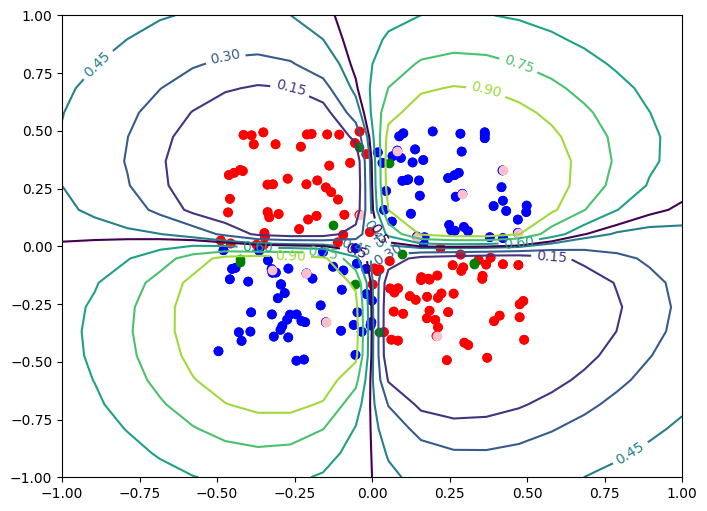

In [48]:
final_inducing_points = model.variational_strategy.inducing_points

fig, ax = plt.subplots(figsize = (8, 6))
CS = ax.contour(x1_test.numpy(), x2_test.numpy(), class_probs.numpy().reshape((20,20)))
ax.clabel(CS, inline=True, fontsize=10)
CS = ax.contour(x1_test.numpy(), x2_test.numpy(), class_probs.numpy().reshape((20,20)), levels = [0.5])
ax.clabel(CS, inline=True, fontsize=10)
plt.scatter(train_x_c[:,0].numpy(), train_x_c[:,1].numpy(), c = color)
plt.scatter(train_x_c[:,0].numpy(), train_x_c[:,1].numpy(), c = color)
plt.scatter(initial_inducing_points[:,0].numpy(), initial_inducing_points[:,1].numpy(), c = "pink")
with torch.no_grad():
  plt.scatter(final_inducing_points[:,0].numpy(), final_inducing_points[:,1].numpy(), c = "green")

We observe that the inducing points tend to concentrate near the decision boundaries.

## **Task 7**

Intialize the inducing points in the previous problem in an adversial way. For that, uncomment the code below the generation of the initial inducing points. Train the model again and see how the inducing points spread across the input space.